
# CSCI E-89 Deep Learning
## LAB 03: Regularizers - MNIST Classifier

### Regularization

Regularization in Keras refers to techniques used to prevent overfitting in neural networks by adding a penalty to the loss function during optimization. This penalty discourages the model from learning overly complex patterns from the training data, leading to better generalization on unseen data.

In [25]:
# Objective : This Notebook introduces Keras API and different options
# Regularizers


In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import keras
import numpy as np
import datetime

In [29]:
print (tf.__version__)
print (keras.__version__)
tf.random.set_seed(123)

2.20.0
3.11.3


#### Load MNIST Data 
##### http://yann.lecun.com/exdb/mnist/

#The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. 
#The digits have been size-normalized and centered in a fixed-size image.

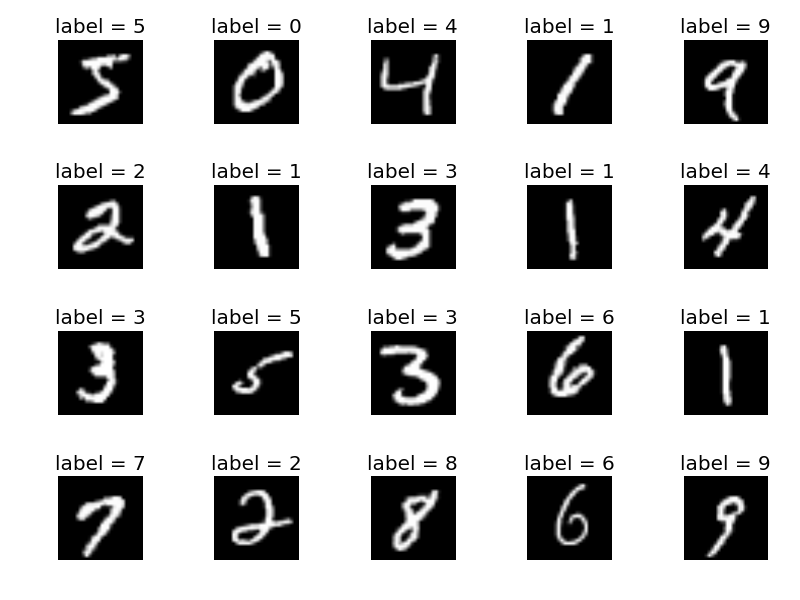

In [30]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0         #Convert the samples from integers to floating-point numbers

In [31]:
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(60000, 28, 28) train samples
(10000, 28, 28) test samples


In [32]:
# How does our Data look ? These are images converted to binary pixel values in a 28 x 28 form for number "5" 

x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [33]:
y_train[0]

np.uint8(5)

#### Build the model 

In [34]:
# Build Model
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(10 , activation='softmax')
])



In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Specifying the input shape - 

The model needs to know what input shape it should expect. For this reason, the first layer in a `Sequential` model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. There are several possible ways to do this:

- pass an `input_shape` argument to the first layer. This is a shape tuple (a tuple of integers or `None` entries, where `None` indicates that any positive integer may be expected). In `input_shape`, the batch dimension is not included.
- pass instead a `batch_input_shape` argument, where the batch dimension is included. This is useful for specifying a fixed batch size (e.g. with stateful RNNs).
- some 2D layers, such as `Dense`, support the specification of their input shape via the argument `input_dim`, and some 3D temporal layers support the arguments `input_dim` and `input_length`.

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Three snippets below are strictly equivalent:




In [36]:
#Note that the output for each observation is 10 dimensional while each label is a single number. 
#We dealt with this before by building one-hot encoding into our loss function. 
#Here we'll manually one-hot encode the labels instead.

from keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot  = one_hot(y_test)

#### Compilation

Before training a model, you need to configure the learning process, which is done via the `compile` method. It receives three arguments:

- an optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the `Optimizer` class. 
- a loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as `categorical_crossentropy` or `mse`), or it can be an objective function. 
- a list of metrics. For any classification problem you will want to set this to `metrics=['accuracy']`. 

In [37]:
# logits
# The vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily 
# then passed to a normalization function. If the model is solving a multi-class classification problem, logits 
# typically become an input to the softmax function. The softmax function then generates a vector of (normalized) 
# probabilities with one value for each possible class.

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

----

#### Training

For training a model, you will typically use the `fit` function.

`model.fit` has several optional parameters:

- `verbose`: how often the progress log is printed (0 for no log, 1 for progress bar logging, 2 for one line per epoch)
- `callbacks`: a list of callback objects that perform actions at certain events (see below)
  
  Callbacks can be passed to keras methods such as fit(), evaluate(), and predict() in order to hook into the various stages of the model training, evaluation, and inference lifecycle.
  
- `validation_split`: splits the training data into training and validation sets. The value passed corresponds to the fraction of the data used for validation ( 
- `validation_data`: when you already have a validation set, pass a list in the format `[input, output]` here. Overrides `validation_split`.
- `shuffle` (default: `True`): shuffles the training data at each epoch.
- `class_weight` and `sample_weight`: used when you want to give different weights during training for certain classes or samples.

#### Regularizers and Constraints - Get better generalization

Neural networks usually have a very large number of parameters, which may lead to overfitting in many cases. There's a large number of methods for regularization,below are some common methods.

For more details and theoretical grounds for the regularization methods described here, a good reference is [Chapter 7 of the Deep Learning Book](http://www.deeplearningbook.org/contents/regularization.html).

##### Regularizers (`keras.regularizers`)
- `l1(l=0.01)`: L1 weight regularization penalty, also known as LASSO
- `l2(l=0.01)`: L2 weight regularization penalty, also known as weight decay, or Ridge
- `l1l2(l1=0.01, l2=0.01)`: L1-L2 weight regularization penalty, also known as ElasticNet




##### Dropout
Applies Dropout to the input.

Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, 
which helps prevent overfitting.The key idea is to randomly drop units (along with their connections) from the 
neural network during training. This prevents units from co-adapting too much.

http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

In [47]:
# Regularized model

from keras import regularizers
from keras.layers import Dropout

reg_model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001),activation='relu'),
  keras.layers.Dense(64, kernel_regularizer=regularizers.l1(0.01),activation='relu'),
  keras.layers.Dropout(rate=0.5),  # Dropout 50% of the features from the dense layer
  keras.layers.Dense(10 , activation='softmax')
])


#loss_reg_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

reg_model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])


history = reg_model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test))


Epoch 1/5


/Users/umarala/anaconda3/envs/dl2025/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8209 - loss: 1.4143 - val_accuracy: 0.9156 - val_loss: 0.6784
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8847 - loss: 0.7468 - val_accuracy: 0.9277 - val_loss: 0.5863
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8986 - loss: 0.6617 - val_accuracy: 0.9334 - val_loss: 0.5260
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9064 - loss: 0.6149 - val_accuracy: 0.9385 - val_loss: 0.4909
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9102 - loss: 0.5872 - val_accuracy: 0.9425 - val_loss: 0.4654


<b>Note</b> that the call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let's take a look at it

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy:

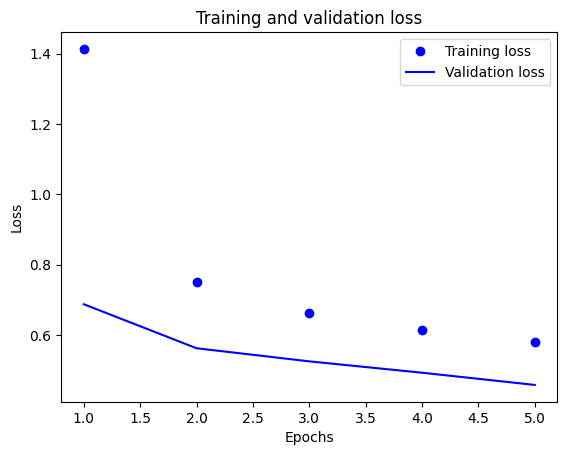

In [40]:
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

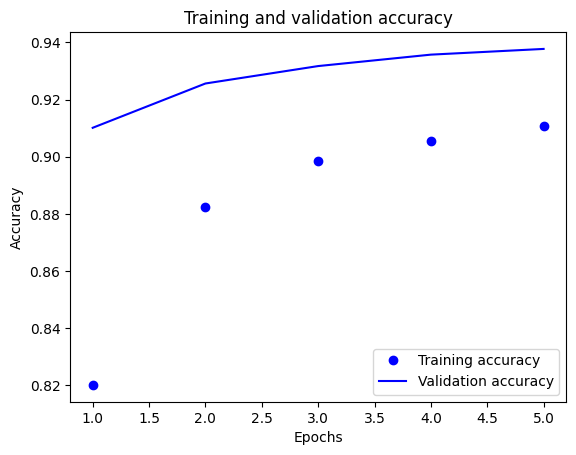

In [41]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
reg_predictions = reg_model.predict(x_test[97:98])

print('\n Reg Predictions:')
print(np.argmax(reg_predictions, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Reg Predictions:
[7]


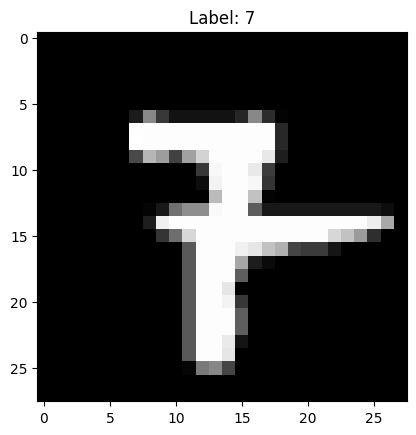

In [43]:
from matplotlib import pyplot as plt
img = np.array(x_test[97:98], dtype='float')
pixels = img.reshape((28, 28))
plt.title('Label: {}'.format(np.argmax(reg_predictions, axis=1)[0]))
plt.imshow(pixels, cmap='gray')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


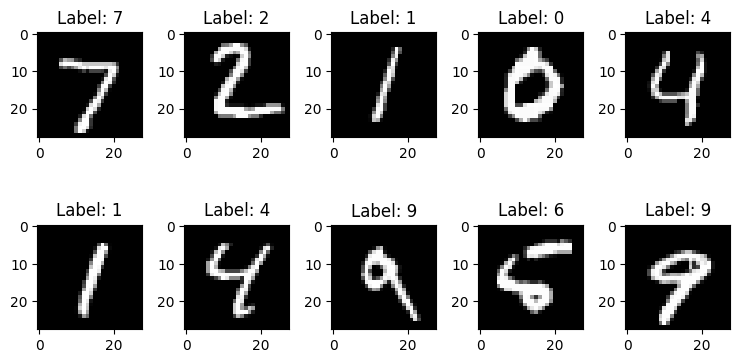

In [44]:
num_row = 2
num_col = 5
# plot images of the first 10 labels
reg_predictions = reg_model.predict(x_test)
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(reg_predictions, axis=1)[i]))
plt.tight_layout()
plt.show()

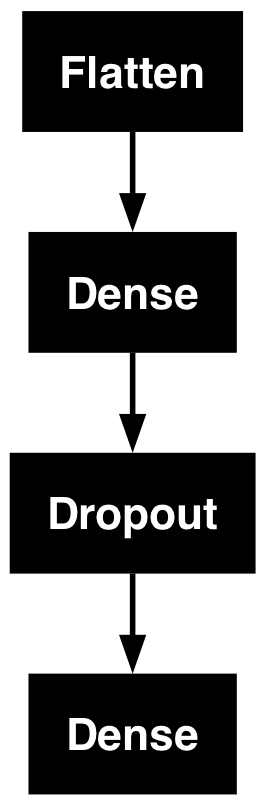

In [45]:
tf.keras.utils.plot_model(model)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
reg_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)